In [1]:
import random
import time
import os

from tqdm.notebook import tqdm

import cv2
import numpy as np

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim

from PIL import Image
from IPython import display

from torchvision.transforms import transforms
import torch.utils.data
from torchsummary import summary

import matplotlib.pyplot as plt
import itertools

from pytorchCycleGANandpix2pix.models import networks as offnets
from pytorchCycleGANandpix2pix.util.image_pool import ImagePool
from pytorchCycleGANandpix2pix.util.util import tensor2im

import cyclegan_models

In [2]:
def revert_normalisation(tensor):
    return (tensor.permute(1, 2, 0) + 1) / 2

def revert_normalisation_batch(tensors):
    return (tensors.permute(0, 2, 3, 1) + 1) / 2

In [3]:
device = "cuda"

In [18]:
model_dir = "./runs/1679338115.1399138/200"
x_to_y = False

In [19]:
model = cyclegan_models.Generator(6)
model.load_state_dict(torch.load(f"{model_dir}/{'G' if x_to_y else 'F'}.pth"))
model.eval()
model.to(device)
;

''

In [20]:
dist_test_image_loc = "./selected_data/experiment_stratified_selection_1679231577.167669/Y/train/half_body_55.jpg"
non_dist_test_image_loc = "./selected_data/experiment_stratified_selection_1679231577.167669/Y/test/half_body_5.jpg"

In [21]:
dist_test_image = cv2.cvtColor(cv2.imread(dist_test_image_loc), cv2.COLOR_BGR2RGB)
non_dist_test_image = cv2.cvtColor(cv2.imread(non_dist_test_image_loc), cv2.COLOR_BGR2RGB)

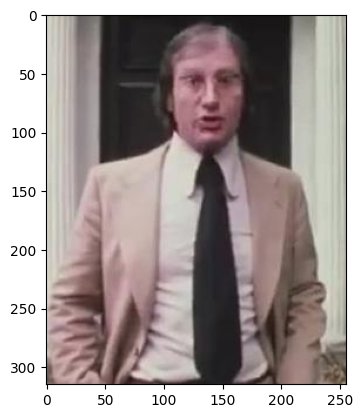

In [22]:
plt.imshow(dist_test_image)

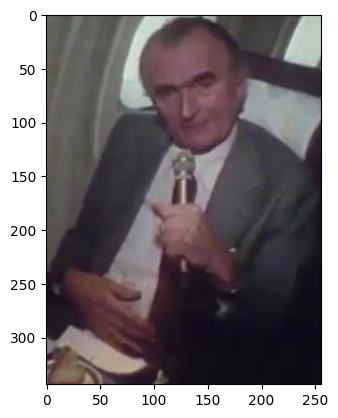

In [23]:
plt.imshow(non_dist_test_image)

In [24]:
preprocess_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [25]:
def revert_normalisation(tensor):
    return (tensor.permute(1, 2, 0) + 1) / 2

In [26]:
dist_test_tensor = preprocess_transform(dist_test_image).unsqueeze(0).to(device)
non_dist_test_tensor = preprocess_transform(non_dist_test_image).unsqueeze(0).to(device)

In [27]:
with torch.no_grad():
    dist_transferred = model(dist_test_tensor)
    non_dist_transferred = model(non_dist_test_tensor)

In [28]:
dist_transferred_img = revert_normalisation(dist_transferred.squeeze().cpu())
non_dist_transferred_img = revert_normalisation(non_dist_transferred.squeeze().cpu())

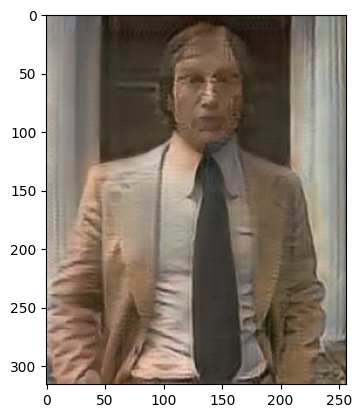

In [29]:
plt.imshow(dist_transferred_img)

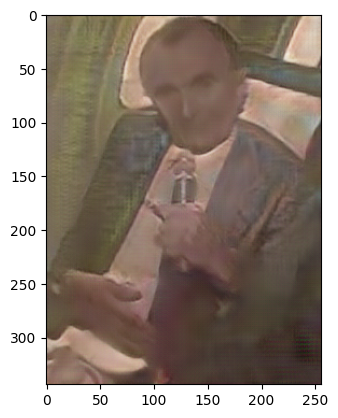

In [30]:
plt.imshow(non_dist_transferred_img)

In [31]:
def transfer_style_to_batch(cv2_images):
    imgs = [preprocess_transform(img) for img in cv2_images]
    imgs = torch.stack(imgs).to(device)
    
    with torch.no_grad():
        imgs_transferred = model(imgs)
    
    imgs_transferred = [revert_normalisation(img_t.cpu()) for img_t in imgs_transferred]
    return imgs_transferred

In [32]:
frame_locs = [
    "./examples/h2zframes/hv_0001.jpg",
    "./examples/h2zframes/hv_0002.jpg"
]

In [81]:
loaded_frames = [cv2.cvtColor(cv2.imread(frame_loc), cv2.COLOR_BGR2RGB) for frame_loc in frame_locs]

In [82]:
transferred_frames = transfer_style_to_batch(loaded_frames)

In [86]:
for i, frame in enumerate(transferred_frames):
    cv2.imwrite(f"./examples/hv_000{i}_t.jpg", cv2.cvtColor(frame.numpy() * 255, cv2.COLOR_RGB2BGR))

In [33]:
video_in_loc = "./data/Test/Test Movie.mp4"
video_out_loc = "./examples/transferred_test_vid_srandom_200.mp4"
batch_size = 4

In [34]:
video_in = cv2.VideoCapture(video_in_loc)

In [35]:
def process_video(video, save_loc):
    # Try to delete the existing saved file
    try:
        os.remove(save_loc)
    except OSError:
        pass 
    
    fps = int(video.get(cv2.CAP_PROP_FPS))
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    
    success, frame = video.read()
    height, width, _ = frame.shape
    
    frame_buffer = []
    video_out = cv2.VideoWriter(save_loc, -1, fps, (width, height))
    
    with tqdm(total=total_frames) as progress:
        while success:
            frame_buffer.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

            if len(frame_buffer) == batch_size:
                transferred_frames = transfer_style_to_batch(frame_buffer)

                for out_frame in transferred_frames:
                    coloured_out_frame = cv2.cvtColor((out_frame.numpy() * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)
                    video_out.write(coloured_out_frame)

                frame_buffer = []

            success, frame = video.read()
            progress.update(1)
    
    if len(frame_buffer) != 0:
        # Process any additional final frames that don't make a full batch
        transferred_frames = transfer_style_to_batch(frame_buffer)

        for out_frame in transferred_frames:
            coloured_out_frame = cv2.cvtColor((out_frame.numpy() * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)
            video_out.write(coloured_out_frame)
    
    video_out.release()

In [36]:
process_video(video_in, video_out_loc)

  0%|          | 0/1645 [00:00<?, ?it/s]